In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dir = '/content/drive/MyDrive/archive/seg_train/seg_train'
test_dir = '/content/drive/MyDrive/archive/seg_test/seg_test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information
print(f"Train dataset classes: {train_dataset.classes}")
print(f"Test dataset classes: {test_dataset.classes}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Train dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Test dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of training batches: 439
Number of test batches: 94


In [6]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 37 * 37, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move model to the appropriate device
model = CNN(num_classes=6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=87616, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch [1/10], Loss: 0.9112, Accuracy: 65.21%
Test Loss: 0.6746, Test Accuracy: 75.70%
Epoch [2/10], Loss: 0.5695, Accuracy: 79.41%
Test Loss: 0.5440, Test Accuracy: 81.40%
Epoch [3/10], Loss: 0.4579, Accuracy: 83.48%
Test Loss: 0.5041, Test Accuracy: 82.30%
Epoch [4/10], Loss: 0.3814, Accuracy: 86.43%
Test Loss: 0.5196, Test Accuracy: 81.60%
Epoch [5/10], Loss: 0.3054, Accuracy: 89.31%
Test Loss: 0.4924, Test Accuracy: 83.13%
Epoch [6/10], Loss: 0.2378, Accuracy: 91.81%
Test Loss: 0.5213, Test Accuracy: 83.77%
Epoch [7/10], Loss: 0.1873, Accuracy: 93.59%
Test Loss: 0.5793, Test Accuracy: 82.17%
Epoch [8/10], Loss: 0.1524, Accuracy: 94.77%
Test Loss: 0.6314, Test Accuracy: 83.07%
Epoch [9/10], Loss: 0.1252, Accuracy: 95.85%
Test Loss: 0.6719, Test Accuracy: 81.60%
Epoch [10/10], Loss: 0.0911, Accuracy: 97.12%
Test Loss: 0.7097, Test Accuracy: 82.37%


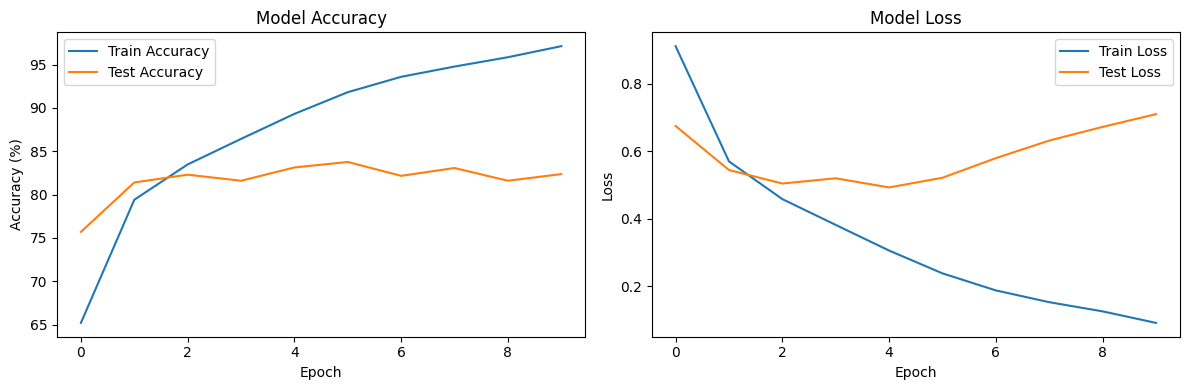

In [33]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

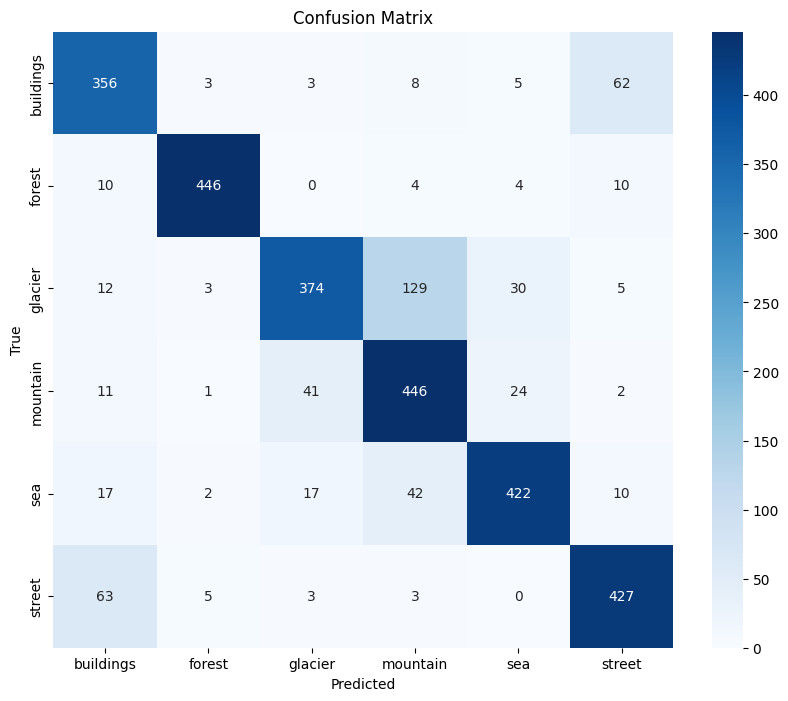

Overall Accuracy: 0.8237


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_names, device):
    # Set the model to evaluation mode
    model.eval()

    # Lists to store true labels and predictions
    all_labels = []
    all_predictions = []

    # Iterate over the test set
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Store the true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print the accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f'Overall Accuracy: {accuracy:.4f}')

# Assuming you have your model, test_loader, and device defined
# Replace 'model', 'test_loader', and 'device' with your actual variables
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
plot_confusion_matrix(model, test_loader, class_names, device)

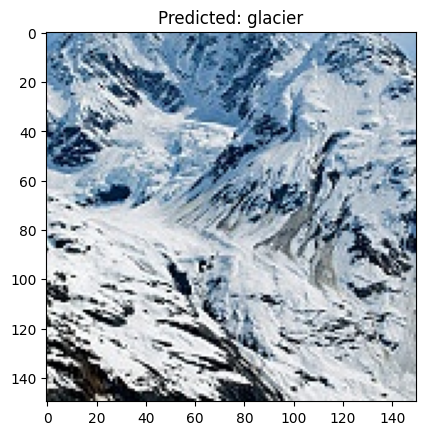

Predicted class: glacier


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

# Define a function to load and preprocess an image
def predict_image(image_path, model, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the appropriate device
    image = image.to(device)

    # Make the model predict
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Load a random image from the pred folder

pred_dir = '/content/drive/MyDrive/archive/seg_pred/seg_pred'  # Path to the pred folder
image_file = random.choice(os.listdir(pred_dir))
image_path = os.path.join(pred_dir, image_file)

# Predict the class of the image
predicted_class_index = predict_image(image_path, model, device)
predicted_class = train_dataset.classes[predicted_class_index]

# Display the image along with the predicted class
def imshow(image_path, title=None):
    image = Image.open(image_path)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

imshow(image_path, title=f'Predicted: {predicted_class}')
print(f'Predicted class: {predicted_class}')
